# Neural Networks in PyTorch
## Part 8: Audio Acquisition and Analysis
*Yen Lee Loh, 2022-11-26*

---
## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import time
from matplotlib.patches import Ellipse
import torch
from torch import nn


def rescale (x, x1, x2, y1, y2):
  return y1 + (y2-y1)/(x2-x1) * (x-x1)
rescale = np.frompyfunc(rescale, 5, 1)

---
## 2. Record one word

In [8]:
audio = pyaudio.PyAudio()   # May have to run this a couple of times

In [78]:
RATE = 44100             # sampling frequency
CHUNK = 4096             # buffer size
TIMEOUT = 5              # if user doesn't respond by this time, quit
AUDIOCLIPDURATION = 1    # duration of each standard clip to produce
THRESHOLD_ON = 0.1       # 
THRESHOLD_OFF = 0.02

stream = audio.open (format=pyaudio.paInt16, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNK)

print ("Listening for audio...")
dataFrames = []
baselineVolumeList = [0.02]
for iFrame in range(0, int(RATE/CHUNK*TIMEOUT)):
  data = stream.read(CHUNK)                    # list of bytes
  data = np.frombuffer(data, dtype=np.int16)   # list of 16-bit integers
  volume = np.max (np.abs((data - np.mean (data)))) / 32768.
  if iFrame%10==0:
    print ("  Volume: {:2.0f}%".format(volume*100), int(100*volume)*'@' + (100-int(100*volume))*'.')
  if (volume > THRESHOLD_ON):
    dataFrames.append (data)
    break
  baselineVolumeList += [volume]

print ("Recording triggered!")
THRESHOLD_OFF = 2*np.mean (np.array(baselineVolumeList))
print ("Off threshold set at ,", THRESHOLD_OFF)

PATIENCE = 10
iPatience = PATIENCE
for iFrame in range(0, int(RATE/CHUNK*AUDIOCLIPDURATION)):
  data = stream.read(CHUNK)                    # list of bytes
  data = np.frombuffer(data, dtype=np.int16)   # list of 16-bit integers
  volume = np.max (np.abs((data - np.mean (data)))) / 32768. 
  print ("  Volume: {:2.0f}%".format(volume*100), int(100*volume)*'@' + (100-int(100*volume))*'.')
  dataFrames.append (data)
  
stream.stop_stream()
stream.close()
#audio.terminate()

data = np.array(dataFrames).flatten()
nSamples = len(data)
print ("Number of samples recorded =", nSamples)

stream=audio.open(44100, 1, pyaudio.paInt16, output=True); stream.write(data); stream.close()

Listening for audio...
  Volume:  6% @@@@@...............................................................................................
  Volume:  2% @...................................................................................................
Recording triggered!
Off threshold set at , 0.07093550750187465
  Volume:  7% @@@@@@..............................................................................................
  Volume: 19% @@@@@@@@@@@@@@@@@@..................................................................................
  Volume: 11% @@@@@@@@@@@.........................................................................................
  Volume:  5% @@@@................................................................................................
  Volume:  6% @@@@@...............................................................................................
  Volume:  4% @@@@..........................................................................................

---
## 3. Record many words

In [3]:
audio = pyaudio.PyAudio()   # May have to run this a couple of times

In [5]:
WORDS = 10
RATE = 44100             # sampling frequency
CHUNK = 1024             # buffer size
TIMEOUT = 4              # if user doesn't respond by this time, quit
AUDIOCLIPDURATION = 1    # duration of each standard clip to produce
THRESHOLD_ON = 0.2       # 
THRESHOLD_OFF = 0.02

istream = audio.open (format=pyaudio.paInt16, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNK)
audioclips = []

time.sleep(0.25)         # give enough time for "Shift-Enter" to be released, so it doesn't trigger mic
try:
  for jWord in range(WORDS):
    print ("Speak now!")
    dataFrames = []
    baselineVolumeList = [0.02]
    for iFrame in range(0, int(RATE/CHUNK*TIMEOUT)):
      data = istream.read(CHUNK)                    # list of bytes
      data = np.frombuffer(data, dtype=np.int16)   # list of 16-bit integers
      volume = np.max (np.abs((data - np.mean (data)))) / 32768.
      if (volume > THRESHOLD_ON):
        dataFrames.append (data)
        break
      baselineVolumeList += [volume]
      if iFrame == int(RATE/CHUNK*TIMEOUT)-1:
        raise Exception("Recording timed out after {} seconds of silence.".format(TIMEOUT)) 

    baselineVolume = np.mean(np.array(baselineVolumeList))   # noise floor
    THRESHOLD_OFF = 2*baselineVolume
    THRESHOLD_ON  = 3*baselineVolume
    print ("Recording word", jWord)   #, ".    Off threshold set at ", THRESHOLD_OFF)

    for iFrame in range(0, int(RATE/CHUNK*AUDIOCLIPDURATION)):
      data = istream.read(CHUNK)                    # list of bytes
      data = np.frombuffer(data, dtype=np.int16)   # list of 16-bit integers
      dataFrames.append (data)

    data = np.array(dataFrames).flatten() [0:RATE*AUDIOCLIPDURATION]
    audioclips.append (data)

except Exception as e:
  print ("Exception: ", e)
    
istream.stop_stream()
istream.close()
print ("All done, thank you!")

Speak now!
Recording word 0
Speak now!
Recording word 1
Speak now!
Recording word 2
Speak now!
Recording word 3
Speak now!
Recording word 4
Speak now!
Recording word 5
Speak now!
Recording word 6
Speak now!
Recording word 7
Speak now!
Recording word 8
Speak now!
Recording word 9
All done, thank you!


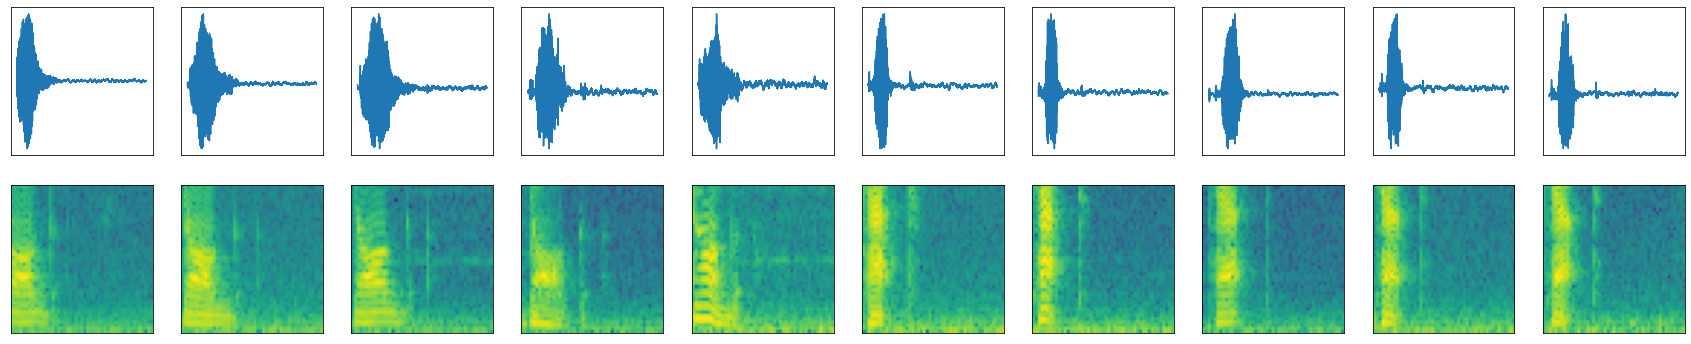

In [6]:
#======== SPECTROGRAMS
kmax = len(audioclips)
fig,axs=plt.subplots(figsize=(kmax*3,2*3))
for k in range(kmax):
  audioclip = audioclips[k]
  plt.subplot (2,kmax,1+k)
  plt.plot(audioclip)
  plt.xticks([]); plt.yticks([])
  plt.subplot (2,kmax,(1+k)+kmax)
  powerSpectrum, freqs, times, graphics = plt.specgram(audioclip, Fs=44100, NFFT=1024); plt.ylim ([0,2000])
  plt.xticks([]); plt.yticks([])

In [7]:
print ("Samples in each clip = ", len(audioclip))
print ("Frequency display goes up to 2000 Hz")

Samples in each clip =  44100
Frequency display goes up to 2000 Hz


In [8]:
#======== PLAYBACK
ostream=audio.open(44100, 1, pyaudio.paInt16, output=True)
for audioclip in audioclips:
  ostream.write(audioclip)
ostream.close()

In [10]:
#======== ASSIGN TRAINING LABELS
yn=np.array([0,0,0,0,0,1,1,1,1,1])

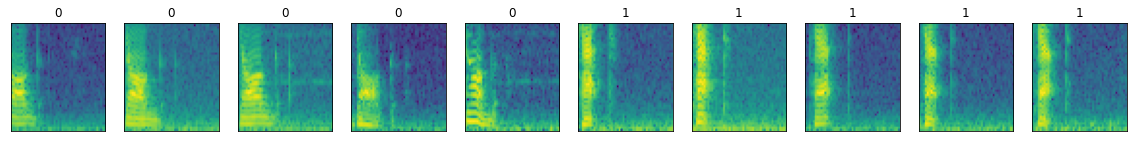

In [11]:
#======== CALCULATE SPECTROGRAMS
xnij = []
for audioclip in audioclips:
  sp, freqs, times = plt.mlab.specgram(audioclip, Fs=44100, NFFT=1024)  # do calculation only
  sp = sp[:50,:]                    # take only the first 50 frequency bins
  sp = np.flipud( np.log(sp) )
  sp = rescale (sp, np.min(sp), np.max(sp), 0, 1)
  sp = np.array (sp, dtype=float)
  xnij += [sp]
xnij = np.array (xnij)              # note n is audioclip index, i is frequency index, j is time index
#======== VISUALIZE SPECTROGRAMS
nmax = len(xnij)
fig,axs=plt.subplots(figsize=(nmax*2,2))
for n in range(nmax):
  plt.subplot (1,nmax,(1+n))
  plt.imshow (xnij[n], aspect='auto'); plt.title (yn[n])
  plt.xticks([]); plt.yticks([])

---
## 4. PCA for intensity profiles (time series)

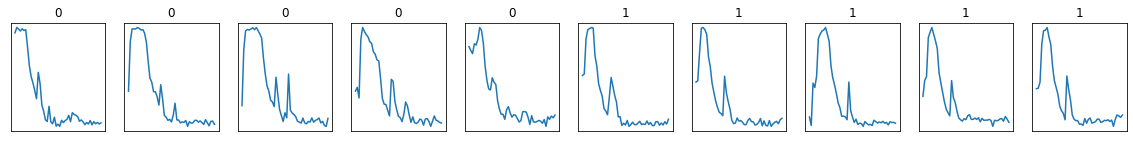

In [12]:
xnd = np.sum(xnij, axis=1)              # sum over frequency
#======== VISUALIZE INTENSITY PROFILES
fig,axs=plt.subplots(figsize=(nmax*2,2))
for n in range(nmax):
  plt.subplot (1,nmax,(1+n))
  plt.plot (xnd[n]) ; plt.title (yn[n])
  plt.xticks([]); plt.yticks([])

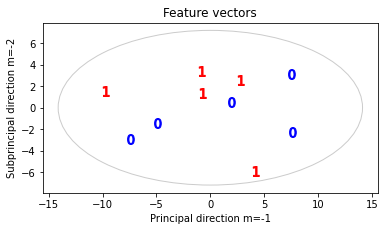

In [13]:
#======== SHIFT AND NORMALIZE THE INPUT VECTORS
und = xnd - np.mean(xnd,axis=0)
und = und/np.std(und,axis=0)
#======== CALCULATE COVARIANCE MATRIX AND FIND TWO MOST IMPORTANT EIGENVECTORS
Cdd = und.T.dot(und) / und.shape[0]
wm,vdm = np.linalg.eigh (Cdd)
fnm = und.dot(vdm[:,[-1,-2]])
#======== VISUALIZE SCATTER IN FEATURE SPACE
group0 = np.where(yn==0)[0]
group1 = np.where(yn==1)[0]
plt.plot (fnm[group0,0], fnm[group0,1], 'b', marker=r'$0$', markersize=10, linestyle='none')
plt.plot (fnm[group1,0], fnm[group1,1], 'r', marker=r'$1$', markersize=10, linestyle='none')
plt.xlabel ('Principal direction m=-1'); plt.ylabel ('Subprincipal direction m=-2'); plt.title ('Feature vectors')
plt.gca().set_aspect ('equal')
rm = np.sqrt(np.abs(wm)) # semiaxes of 1-sigma ellipse
plt.gca().add_patch (Ellipse((0,0), 5*rm[-1], 5*rm[-2], edgecolor='#CCC', facecolor=(0,0,0,0)));

PCA doesn't separate the classes properly.

---
## 5. PCA for spectrograms

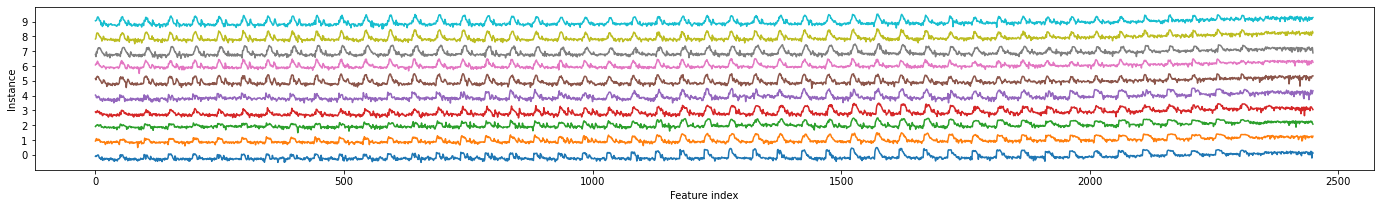

In [14]:
nmax,imax,jmax=xnij.shape
xnd = xnij.reshape (nmax,-1)
nmax,dmax = xnd.shape
fig,axs=plt.subplots(figsize=(24,3))
for n in range(nmax):
  plt.plot (xnd[n] + n*1.0 - 0.5)
plt.xlabel ('Feature index'); plt.ylabel('Instance'); plt.yticks (range(nmax));

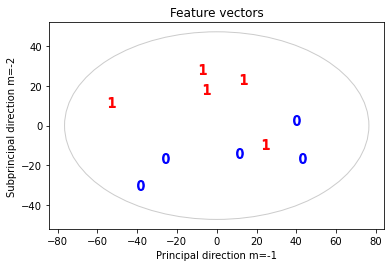

In [15]:
#======== SHIFT AND NORMALIZE THE INPUT VECTORS
und = xnd - np.mean(xnd,axis=0)
und = und/np.std(und,axis=0)
#======== CALCULATE COVARIANCE MATRIX AND FIND TWO MOST IMPORTANT EIGENVECTORS
Cdd = und.T.dot(und) / und.shape[0]
wm,vdm = np.linalg.eigh (Cdd)
fnm = und.dot(vdm[:,[-1,-2]])
#======== VISUALIZE SCATTER IN FEATURE SPACE
group0 = np.where(yn==0)[0]
group1 = np.where(yn==1)[0]
plt.plot (fnm[group0,0], fnm[group0,1], 'b', marker=r'$0$', markersize=10, linestyle='none')
plt.plot (fnm[group1,0], fnm[group1,1], 'r', marker=r'$1$', markersize=10, linestyle='none')
plt.xlabel ('Principal direction m=-1'); plt.ylabel ('Subprincipal direction m=-2'); plt.title ('Feature vectors')
plt.gca().set_aspect ('equal')
rm = np.sqrt(np.abs(wm)) # semiaxes of 1-sigma ellipse
plt.gca().add_patch (Ellipse((0,0), 5*rm[-1], 5*rm[-2], edgecolor='#CCC', facecolor=(0,0,0,0)));

PCA already sees that there are two distinct classes of audioclips (even though it has no access to the training labels)!

---
## 6. Binary classification for spectrograms

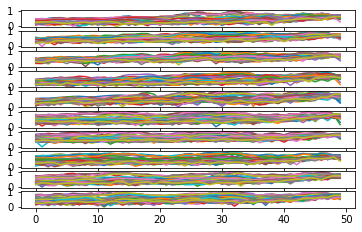

In [17]:
kmax = xnij.shape[0]
for k in range(kmax):
  plt.subplot(1+kmax,1,1+k)
  plt.plot(xnij[k])

In [18]:
xnd=xnij.reshape (nmax,-1); xnd=torch.tensor(xnd,dtype=torch.float32)
ynd=torch.tensor(yn,dtype=torch.float32).reshape(-1,1)
#xnd.dtype, xnd.shape, ynd.shape,  nmax, dmax

In [19]:
#======== TRAIN
model = nn.Sequential(
  nn.Linear(dmax,1), 
  nn.Sigmoid()
)
lossFunc  = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lossHistory = []
model.train()     # choose training mode
for epoch in range(1,20001):
  Ynd = model(xnd)
  loss = lossFunc(Ynd,ynd)
  lossHistory.append (loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


In [21]:
#======== MAKE PREDICTIONS FOR WHOLE TRAINING DATASET
model.eval()     # choose evaluation mode
Yn = model(xnd).detach().numpy().round().flatten().astype(int) # round to either 0 or 1
yn = ynd.detach().numpy().flatten().astype(int)                # this is already an integer
#======== FIND CONFUSION MATRIX Cnn
Cnn = np.zeros ([2, 2], dtype=int)
for n in range(nmax):
  Cnn[yn[n], Yn[n]] += 1
print("Total instances    =", np.sum(Cnn))
print("Misclassifications =", Cnn[0,1]+Cnn[1,0])
print("Error rate         = {:.1f}%".format (100*sum(Yn != yn)/nmax))
print("Confusion matrix   =", Cnn.tolist())

Total instances    = 10
Misclassifications = 0
Error rate         = 0.0%
Confusion matrix   = [[5, 0], [0, 5]]


Training output y, model output Y, and input x (handwritten):


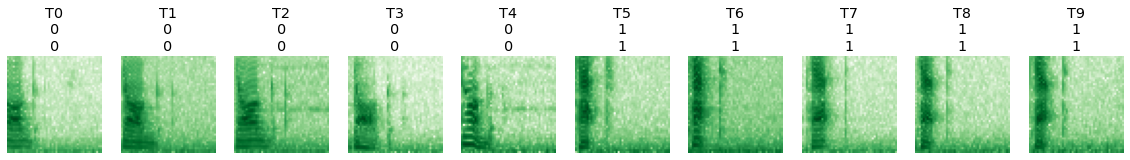

In [22]:
#======== SHOW TRAINING EXAMPLES
iDisplay = min(nmax,20)
print ('Training output y, model output Y, and input x (handwritten):')
plt.figure (figsize=(2*iDisplay,2))
for n in range(iDisplay):
    xd,y,Y = xnd[n],yn[n],Yn[n]
    plt.subplot (1, iDisplay, 1+n)
    plt.axis ('off')
    plt.imshow (xd.reshape(imax,jmax), cmap=('Greens' if Y==y else 'Reds') )
    plt.rc ('font', size=12)
    plt.title ('T{}\n{}\n{}'.format(n,y,Y))

---
## 6. Deploy

Record words for testing:

In [23]:
WORDS = 3
RATE = 44100             # sampling frequency
CHUNK = 4096             # buffer size
TIMEOUT = 4              # if user doesn't respond by this time, quit
AUDIOCLIPDURATION = 1    # duration of each standard clip to produce
THRESHOLD_ON = 0.2       # 
THRESHOLD_OFF = 0.02

istream = audio.open (format=pyaudio.paInt16, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNK)
audioclipsV = []

time.sleep(0.25)         # give enough time for "Shift-Enter" to be released, so it doesn't trigger mic
try:
  for jWord in range(WORDS):
    print ("Speak now!")
    dataFrames = []
    baselineVolumeList = [0.02]
    for iFrame in range(0, int(RATE/CHUNK*TIMEOUT)):
      data = istream.read(CHUNK)                    # list of bytes
      data = np.frombuffer(data, dtype=np.int16)   # list of 16-bit integers
      volume = np.max (np.abs((data - np.mean (data)))) / 32768.
      if (volume > THRESHOLD_ON):
        dataFrames.append (data)
        break
      baselineVolumeList += [volume]
      if iFrame == int(RATE/CHUNK*TIMEOUT)-1:
        raise Exception("Recording timed out after {} seconds of silence.".format(TIMEOUT)) 

    THRESHOLD_OFF = 2*np.mean (np.array(baselineVolumeList))
    print ("Recording word", jWord, ".    Off threshold set at ", THRESHOLD_OFF)

    for iFrame in range(0, int(RATE/CHUNK*AUDIOCLIPDURATION)):
      data = istream.read(CHUNK)                    # list of bytes
      data = np.frombuffer(data, dtype=np.int16)   # list of 16-bit integers
      dataFrames.append (data)

    data = np.array(dataFrames).flatten() [0:RATE*AUDIOCLIPDURATION]
    audioclipsV.append (data)

except Exception as e:
  print ("Exception: ", e)
    
istream.stop_stream()
istream.close()
print ("All done, thank you!")

Speak now!
Recording word 0 .    Off threshold set at  0.03717973263824687
Speak now!
Recording word 1 .    Off threshold set at  0.02169795119762421
Speak now!
Recording word 2 .    Off threshold set at  0.04264743387699128
All done, thank you!


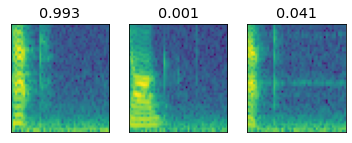

In [24]:
xnijV = []
for audioclip in audioclipsV:
  sp, freqs, times = plt.mlab.specgram(audioclip, Fs=44100, NFFT=1024)  # do calculation only
  sp = sp[:50,:]                    # take only the first 50 frequency bins
  sp = np.flipud( np.log(sp) )
  sp = rescale (sp, np.min(sp), np.max(sp), 0, 1)
  sp = np.array (sp, dtype=float)
  xnijV += [sp]
xnijV = np.array (xnijV)              # note n is audioclip index, i is frequency index, j is time index

#======== DO BINARY CLASSIFICATION
nmaxV = len(xnijV)
xndV=xnijV.reshape (nmaxV,-1); xndV=torch.tensor(xndV,dtype=torch.float32)
YndV=model(xndV).detach().numpy().flatten()

#======== VISUALIZE SPECTROGRAMS
nmaxV = len(xnijV)
fig,axs=plt.subplots(figsize=(nmaxV*2,2))
for n in range(nmaxV):
  plt.subplot (1,nmaxV,(1+n))
  plt.imshow (xnijV[n], aspect='auto'); plt.title ('{:.3f}'.format(YndV[n]))
  plt.xticks([]); plt.yticks([])

Training output y, model output Y, and input x (handwritten):


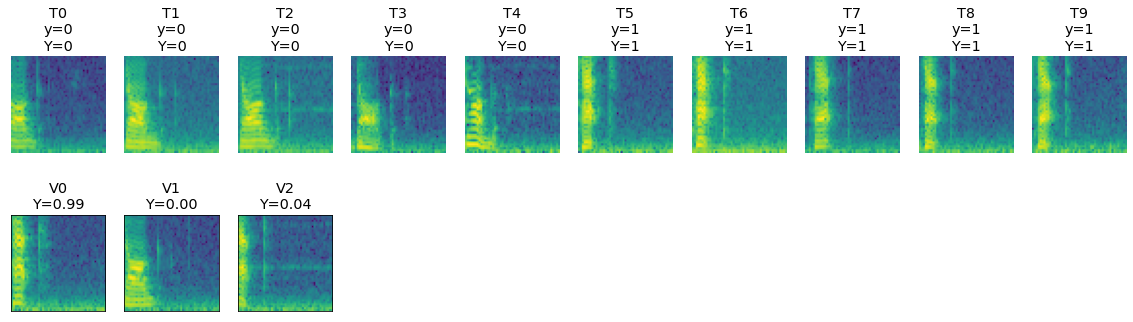

In [25]:
#======== SHOW TRAINING EXAMPLES AGAIN FOR COMPARISON
iDisplay = min(nmax,20)
print ('Training output y, model output Y, and input x (handwritten):')
plt.figure (figsize=(2*iDisplay,5))
for n in range(iDisplay):
  xd,y,Y = xnd[n],yn[n],Yn[n]
  plt.subplot (2, iDisplay, 1+n)
  plt.axis ('off')
  plt.imshow (xd.reshape(imax,jmax))
  plt.rc ('font', size=12)
  plt.title ('T{}\ny={}\nY={}'.format(n,y,Y))
#======== VISUALIZE SPECTROGRAMS
for n in range(nmaxV):
  plt.subplot (2,iDisplay, 1+n+nmax)
  plt.imshow (xnijV[n]) #, aspect='auto'); 
  plt.title ('V{}\nY={:.2f}'.format(n,YndV[n]))
  plt.xticks([]); plt.yticks([])
plt.subplots_adjust (hspace=.4)

In [519]:
#======== PLAYBACK VALIDATION SET
ostream=audio.open(44100, 1, pyaudio.paInt16, output=True)
for audioclip in audioclipsV: ostream.write(audioclip)
ostream.close()

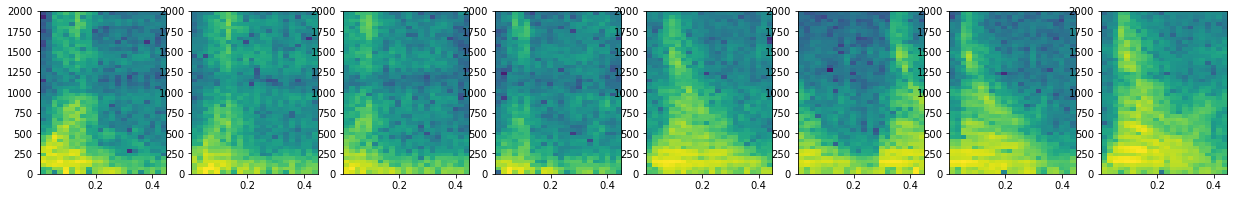

In [335]:
#======== SPECTROGRAMS
fig,axs=plt.subplots(figsize=(24,3))
for k in range(kmax):
  asdf = blah[k]
  plt.subplot (1,1+kmax,1+k)
  powerSpectrum, frequenciesFound, times, fdsa = plt.specgram(asdf, Fs=44100, NFFT=1024); plt.ylim ([0,2000])